In [59]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [60]:
# Global Variables

N = 200 # Image Size
G = 20 # Watermark Size
P = 50 # Max Moment

# Steps

T_STEP = int(P / 4) + 1
I_STEP = int(N / 8) + 1

In [61]:
%run -i ./ownlib/PHT-Library2.ipynb
%run -i ./ownlib/RIW-Library.ipynb
%run -i ./ownlib/Utility.ipynb

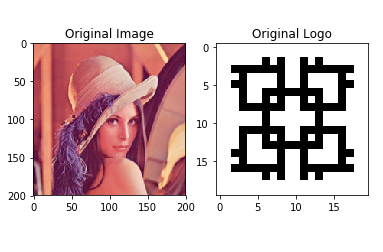

In [62]:
# Import images
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/squares.png', 0)

# Preprocess Image
IMG_BGR = cv2.resize(ori_img, (N, N)) # Original Image
IMG_Y = getYFromBGR(IMG_BGR) #

# Preprocess Logo
LOGO = cv2.resize(ori_logo, (G,G))
LOGO = (LOGO >= 128) * 1

# Show Image and Logo
imgshow([[IMG_BGR, LOGO]], [['Original Image', 'Original Logo']])

Progress: [####################] 100.0%


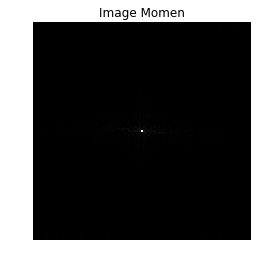

In [63]:
# Calculate Momen of Original Image
MOMEN = transformPHT(IMG_Y, N, P)
imgshow1(MOMEN, 'Image Momen')

Progress: [####################] 100.0%


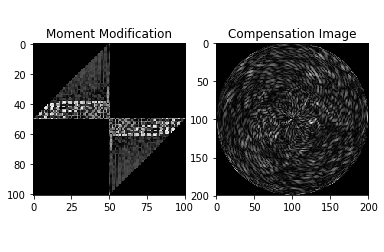

In [64]:
# Calculate Embedded Momen

# Watermarking Power
DELTA = 0.5

# Current Binary Value
matQ = np.floor(np.abs(MOMEN) / DELTA) % 2

# Set Watermark Position
P2 = P * 2 + 1

# Calculate Watermark Matrix
(doubleLogo, doubleFilter) = watermarkEmbed(LOGO, P)
        
# Modified Momen
XI = np.abs(MOMEN) - np.floor(np.abs(MOMEN) / DELTA) * DELTA

OMEGA = - XI
OMEGA = OMEGA + DELTA / 2 * (matQ == doubleLogo)
OMEGA = OMEGA + 3 * DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_or(XI > DELTA / 2, np.abs(MOMEN) < DELTA))
OMEGA = OMEGA - DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_and(XI <= DELTA / 2, np.abs(MOMEN) >= DELTA))

OMEGA = OMEGA / (np.abs(MOMEN) + 0.000000001) * MOMEN
OMEGA = OMEGA * doubleFilter

# Calculate Compensation Image
EPSILON = inversePHT(OMEGA, N, P)

# Show Modified Momen
imgshow([[OMEGA, EPSILON]], [['Moment Modification', 'Compensation Image']])

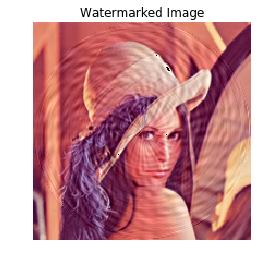

In [65]:
# Add Compensation Image to Original Image
IMG_Y_WATERMARKED = IMG_Y + EPSILON

# Add Original Image back to YCRCB scheme
IMG_WATERMARKED = putYToBGR(IMG_Y_WATERMARKED, IMG_BGR)

imgshow1(IMG_WATERMARKED, 'Watermarked Image')

In [66]:
# Modified function
def attackAndDisplay(image, title):
    processAndDisplayAttack(image, title, LOGO, P, G, DELTA)

Progress: [####################] 100.0%
BE  :  0.0
BER :  0.00%


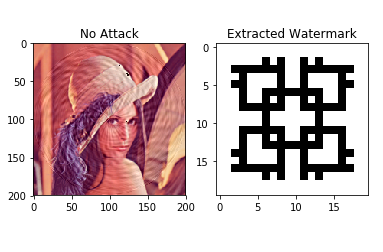

In [67]:
attackAndDisplay(IMG_WATERMARKED, 'No Attack')

Progress: [####################] 100.0%
BE  :  1.0
BER :  0.25%


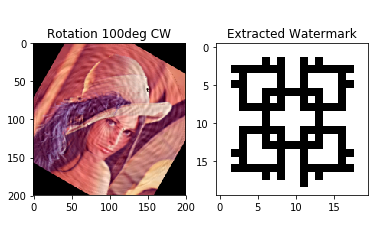

In [68]:
# Attack: Rotation 30 degree
ROTATION_ANGLE = -30
IMG_ROTATE = attackRotation(IMG_WATERMARKED, ROTATION_ANGLE)
attackAndDisplay(IMG_ROTATE, 'Rotation 100deg CW')

Progress: [####################] 100.0%
BE  :  0.0
BER :  0.00%


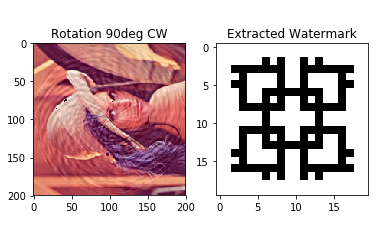

In [69]:
# Attack: Rotation 90 degree
IMG_ROTATE2 = np.rot90(IMG_WATERMARKED)
attackAndDisplay(IMG_ROTATE2, 'Rotation 90deg CW')

Progress: [####################] 100.0%
BE  :  0.0
BER :  0.00%


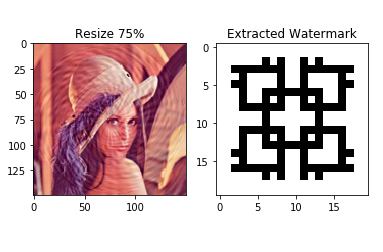

In [70]:
# Attack: Resize 75%
RESIZE_FACTOR = 0.75
IMG_RESIZE = attackResize(IMG_WATERMARKED, int(RESIZE_FACTOR * N))
attackAndDisplay(IMG_RESIZE, 'Resize ' + '{:.0%}'.format(RESIZE_FACTOR))

Progress: [####################] 100.0%
BE  :  233.0
BER :  58.25%


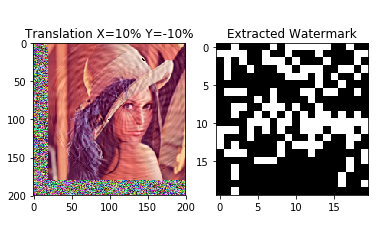

In [71]:
# Attack: Translation

TRANSLATION_X_PERCENTAGE = 0.1
TRANSLATION_Y_PERCENTAGE = -0.1

IMG_TRANSLATE = attackTranslate(IMG_WATERMARKED, TRANSLATION_X_PERCENTAGE, TRANSLATION_Y_PERCENTAGE)
attackAndDisplay(IMG_TRANSLATE, 'Translation X={:.0%} Y={:.0%}'.format(TRANSLATION_X_PERCENTAGE, TRANSLATION_Y_PERCENTAGE))

Progress: [####################] 100.0%
BE  :  36.0
BER :  9.00%


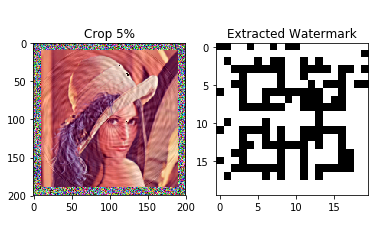

In [72]:
# Attack: FRAME 5%
CROP_PERCENTAGE = 0.05

IMG_CROP = attackCrop(IMG_WATERMARKED, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE)
attackAndDisplay(IMG_CROP, 'Crop ' + '{:.0%}'.format(CROP_PERCENTAGE))

Progress: [####################] 100.0%
BE  :  30.0
BER :  7.50%


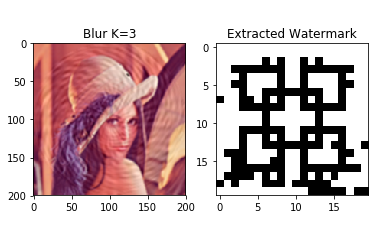

In [73]:
# Attack: BLUR 3x3
BLUR_KERNEL_SIZE = 3

IMG_BLUR = attackBlur(IMG_WATERMARKED, BLUR_KERNEL_SIZE)
attackAndDisplay(IMG_BLUR, 'Blur K={}'.format(BLUR_KERNEL_SIZE))

Progress: [####################] 100.0%
BE  :  40.0
BER :  10.00%


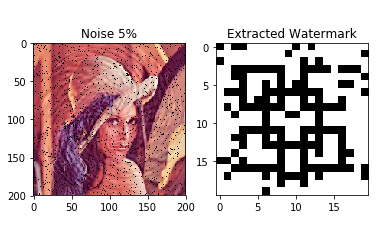

In [74]:
# Attack: RANDOM NOISE 3%

NOISE_PERCENTAGE = 0.05
IMG_NOISE = attackRandomNoise(IMG_WATERMARKED, NOISE_PERCENTAGE)
attackAndDisplay(IMG_NOISE, 'Noise ' + '{:.0%}'.format(NOISE_PERCENTAGE))